In [181]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, recall_score, fbeta_score, accuracy_score

### Part 1 - Exploratory Data Analysis

In [2]:
# load logins.json
data = pd.read_json('logins.json')
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# view summary statistics of data
data.describe()

C:\Users\tscofield\AppData\Local\Temp\ipykernel_6960\3359102907.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


We can see from the summary statistics that this data represents user logins from January 1, 1970 to April 13, 1970. Also, there are some duplicates in the data because there are 93142 observations and 92265 unique logins. It makes most sense to drop these values now.

In [3]:
# drop duplicates
data.drop_duplicates(subset=['login_time'], inplace=True)

In [27]:
data.describe()

C:\Users\tscofield\AppData\Local\Temp\ipykernel_6960\3175101911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,login_time
count,92265
unique,92265
top,1970-01-01 20:13:18
freq,1
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
# check for null values
data.isna().sum()

login_time    0
dtype: int64

Now, we can see that there are no duplicate values and there are no NaNs. We can move on with the prompt.

In [4]:
# add frequency column to keep track of after aggregation
data['freq'] = 1
data.head()

,login_time,freq
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [6]:
# aggregate into 15-minute time intervals using "resample"
data.login_time = pd.to_datetime(data.login_time)
data_agg = data.set_index('login_time').resample('15T',label='right').sum()
data_agg.head()

,freq
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1


In [38]:
# inspect summary statistics of the freq variable
data_agg.describe()

,freq
count,9788.000000
mean,9.426338
std,8.172091
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,68.000000


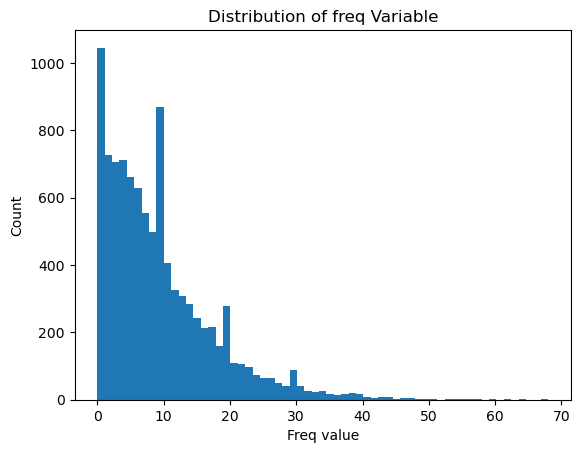

In [42]:
# look at distribution of freq variable
plt.hist(x=data_agg['freq'], bins=len(set(data_agg.freq)))
plt.xlabel('Freq value')
plt.ylabel('Count')
plt.title('Distribution of freq Variable')
plt.show()

We can see that 0 is the most common frequency value, with a couple of other spikes in the data. However, the overall trend is that lower traffic is more common. 

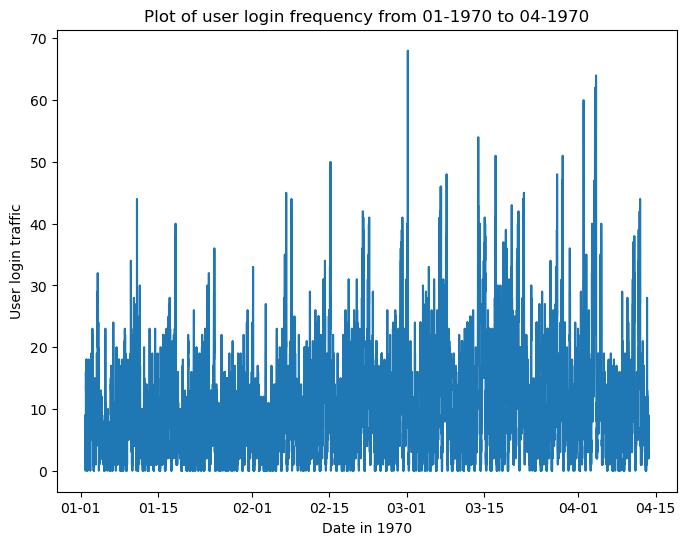

In [8]:
# plot the time series
fig,ax = plt.subplots(figsize=(8,6))

xtick_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m-%d")
#ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

sns.lineplot(data=data_agg, x=data_agg.index, y=data_agg['freq'])
plt.xlabel('Date in 1970')
plt.ylabel('User login traffic')
plt.title('Plot of user login frequency from 01-1970 to 04-1970')
#plt.grid(axis='x')
plt.show()

It is hard to interpret much from this plot because there is so much fluctuation. Let's smooth this plot to see if there are underlying trends.

To do this, we will use a rolling window to average the data. Let's using a rolling window that will average for each day to start.

In [14]:
# using rolling() to find daily average 

# how many 15 minute intervals are there in a day?
daily_intervals = 15*24
data_agg['daily_rolling_avg'] = data_agg.freq.rolling(daily_intervals).mean()
data_agg.head(-10)

,freq,daily_rolling_avg
login_time,,
1970-01-01 20:15:00,2,NaN
1970-01-01 20:30:00,6,NaN
1970-01-01 20:45:00,9,NaN
1970-01-01 21:00:00,7,NaN
1970-01-01 21:15:00,1,NaN
...,...,...
1970-04-13 15:30:00,4,11.722222
1970-04-13 15:45:00,3,11.688889
1970-04-13 16:00:00,2,11.616667


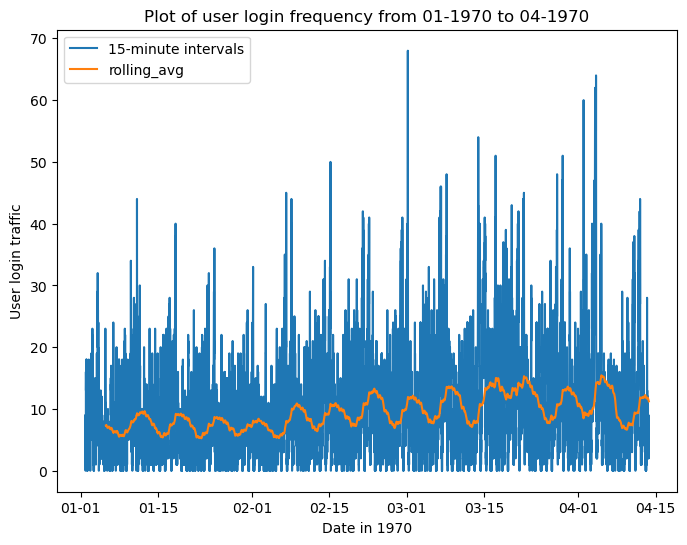

In [61]:
# plot the time series w/ rolling avg
fig,ax = plt.subplots(figsize=(8,6))

#xtick_locator = mdates.DayLocator(interval=15)
year_month_formatter = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(year_month_formatter)

sns.lineplot(data=data_agg, x=data_agg.index, y=data_agg['freq'], label='15-minute intervals')

sns.lineplot(data=data_agg, x=data_agg.index, y=data_agg['daily_rolling_avg'], label='rolling_avg')


plt.xlabel('Date in 1970')
plt.ylabel('User login traffic')
plt.title('Plot of user login frequency from 01-1970 to 04-1970')
plt.show()

We can see that once the data is smoothed, we can see some underlying trends. There is a clear sinusoidal trend in the user login traffic. Let's zoom in to a section of this to measure it's period.

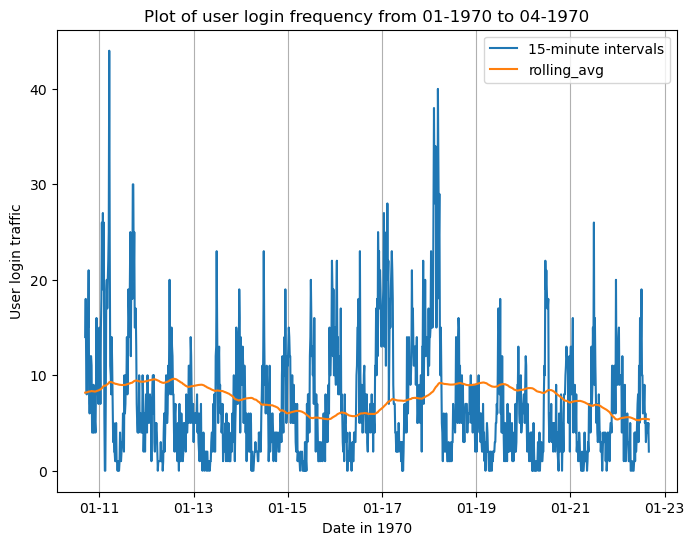

In [44]:
data_subset = data_agg.iloc[850:2000,:]
# plot the time series w/ rolling avg
fig,ax = plt.subplots(figsize=(8,6))

xtick_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(year_month_formatter)
#ax.xaxis.set_major_locator(xtick_locator)

sns.lineplot(data=data_subset, x=data_subset.index, y=data_subset['freq'], label='15-minute intervals')

sns.lineplot(data=data_subset, x=data_subset.index, y=data_subset['daily_rolling_avg'], label='rolling_avg')

plt.xlabel('Date in 1970')
plt.ylabel('User login traffic')
plt.title('Plot of user login frequency from 01-1970 to 04-1970')
plt.grid(axis='x')
plt.show()

Once zoomed in, we can see that there is a spike in user traffic weekly. 

Now let's plot the full decomposition of the time data.

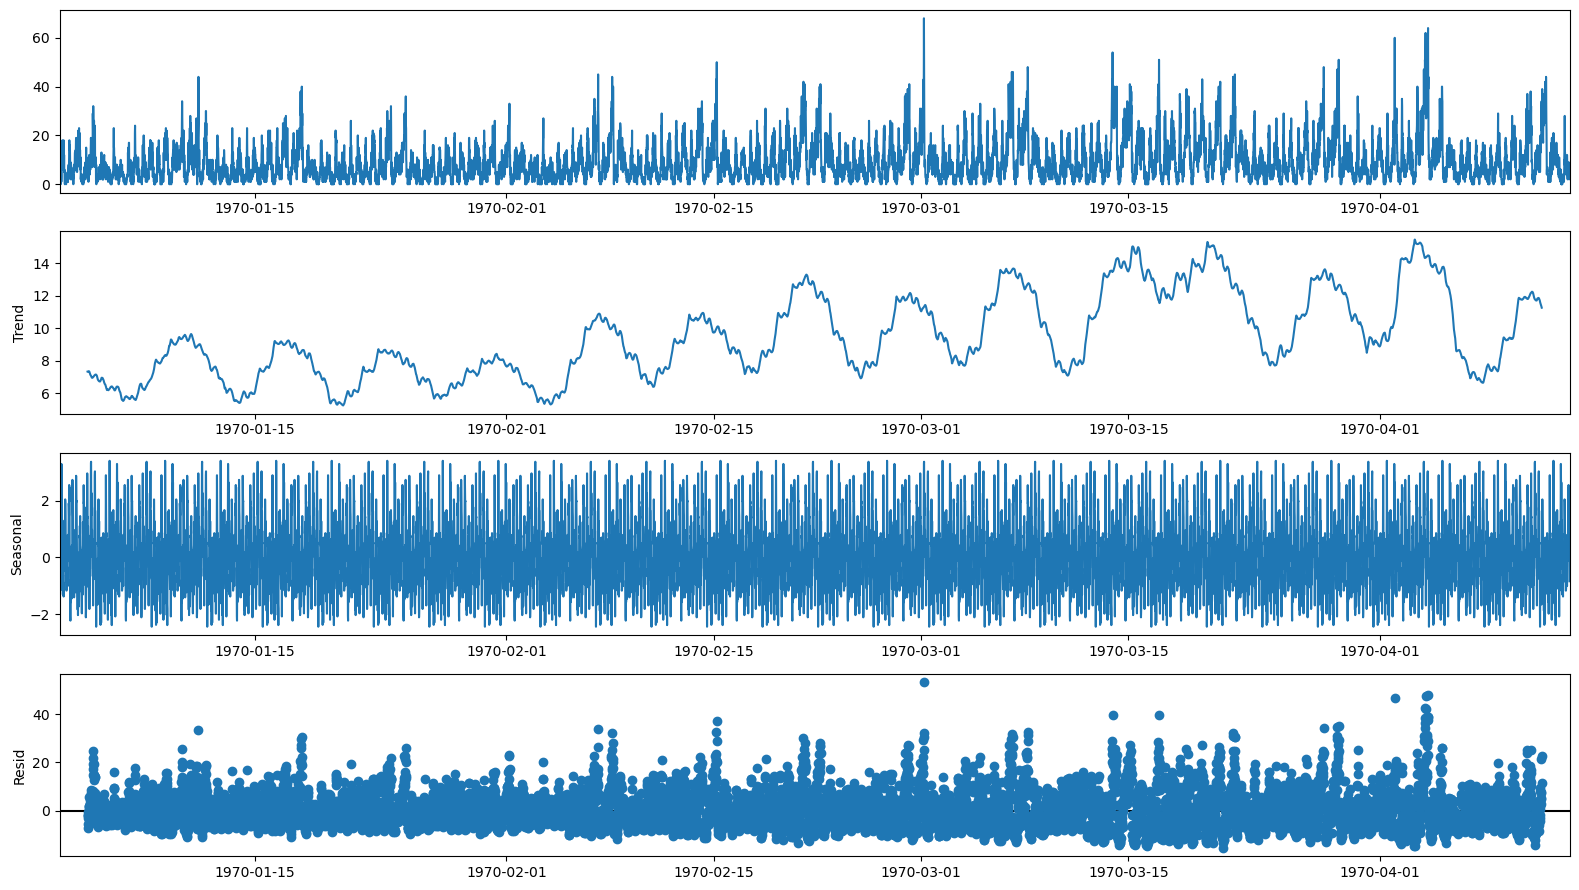

In [46]:
# decomposition
series = data_agg.drop('daily_rolling_avg', axis=1)
result = seasonal_decompose(series, model='additive', period=15*24)
#fig,ax = plt.subplots(figsize=(8,6))
#plt.figure(figsize=(30,35))
fig=result.plot()
fig.set_size_inches((16,9))
fig.tight_layout()
plt.show()

Again, we can see the weekly swings in user traffic from the "trend" plot. However, the seasonal and residual plots to not help shed light on any other trends of the data.

### Part 2 - Experiment and metrics design

1) The key measure of success for this experiment would be the increased traffic, or analogously, increased number of tolls paid (even if they will be reimbursed) on the toll bridge following this new change for driver partners.

2) 

(a) To implement this experiment, we need to have data collected for driver partners before the new toll reimbursement rule goes into place. Then, once the new rule is in effect, we can measure the number of tolls paid on the bridge to see if the rule has an affect on driver's decisions to cross the bridge.

(b) After sufficient data is collected, we can perform a hypothesis test to determine if reimbursing tolls results in higher traffic. If the between-group variation is big enough that there is little or no overlap between groups, the hypothesis test will display a low p-value to represent this. This suggests that the disparities between these groups (pre and post toll reimbursement) are unlikely to have occurred by accident.

(c) Depending on the results of the statistical testing, we can provide recommendations to the city. If there is enough statistical evidence to support the claim that the tolls were what was holding people back from driving across the bridge, we will recommend that the toll continues to be reimbursed as it is helping the communities. On the other hand, if there is not enough statistical evidence, we will recommend that the tolls are not reimbursed as it does not greatly change the number of people traveling from Gotham to Metropolis, and vice versa.

### Part 3 - Predictive modeling

In [158]:
# load logins.json
data = pd.read_json('ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [127]:
# count null values
data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

There are 3 columns with null values: avg_rating_of_driver, phone, and avg_rating_by_driver. Because these are already average values, I will fill them with the average of the column. 

In [159]:
# fill nan values
data['avg_rating_of_driver'] = data['avg_rating_of_driver'].fillna(np.mean(data['avg_rating_of_driver']))
data['avg_rating_by_driver'] = data['avg_rating_by_driver'].fillna(np.mean(data['avg_rating_by_driver']))

In [129]:
# look at phone column
data['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

We will assume that the type of phone that users have will not have a big effect on our prediction. Therefore, it doesn't make sense to simply drop observations with missing phone descriptions. I am going to fill the NaNs in this column with "other". 

In [160]:
# fill nan values
data['phone'] = data['phone'].fillna('other')

In [131]:
# check again for missing values
data.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [132]:
# examine statistics to look for outliers
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


From the summary statistics we can see that a few columns have outliers, trips_in_first_30_days, avg_surge, surge_pct, and avg_dist. 

C:\Users\tscofield\Documents\Anaconda\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


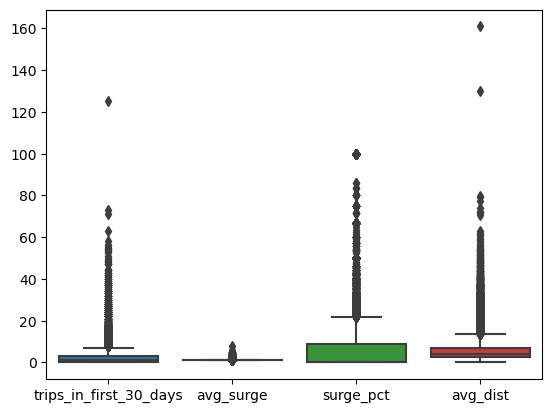

In [152]:
data_sub = data[['trips_in_first_30_days', 'avg_surge', 'surge_pct', 'avg_dist']]
sns.boxplot(data=data_sub)
plt.show()

We can see the many outliers in these features. However, without more context, we do not know if these are unreasonable or fake in our data, therefore, we will leave them for now. Though, it is good to be aware of these values.

In [161]:
# new feature to explain user's account duration
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'], format='%Y-%m-%d')
data['signup_date'] = pd.to_datetime(data['signup_date'], format='%Y-%m-%d')
data['account_duration'] = (data['last_trip_date'] - data['signup_date']).astype('timedelta64[D]').astype('int')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_duration
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47


In [135]:
# look at summary statistics for new column
data[['account_duration']].describe()

,account_duration
count,50000.000000
mean,92.790100
std,62.129822
min,0.000000
25%,27.000000
50%,110.000000
75%,150.000000
max,181.000000


In [162]:
# generate new feature which will be our response variable

active_sixth = np.empty(len(data))
for i in range(len(data)):
    if data.account_duration[i] > 150:
        active_sixth[i] = 1
    else:
        active_sixth[i] = 0
        
active_sixth.sum()

12198.0

In [163]:
# populate data
data['is_active_sixth_month'] = np.round(active_sixth)

In [156]:
print("Percentage retained: " + str(active_sixth.sum()/len(active_sixth)))

Percentage retained: 0.24396


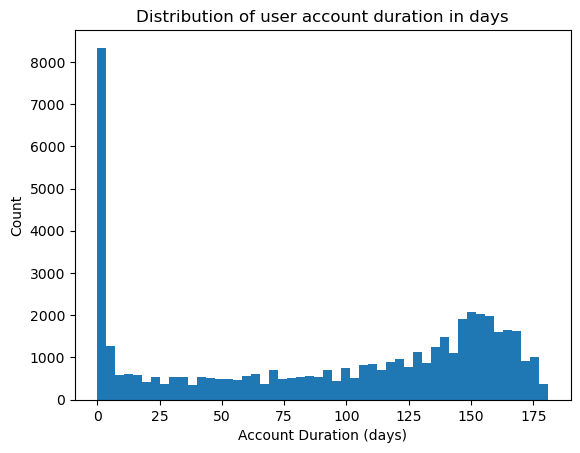

In [140]:
# generate histogram for account durations
plt.hist(data['account_duration'], bins=50)
plt.xlabel('Account Duration (days)')
plt.ylabel('Count')
plt.title('Distribution of user account duration in days')
plt.show()

In [141]:
# what percentage is equal to 1
len(data[data.account_duration == 1])/len(data)

0.08748

We can see that the most common account duration is 1 day, accounting for almost 9% of all users. We also looked at how many users were active in their 6th month. We used a threshold of 150 days to calculate this and found that approximately 24% of users are active in their 6th month.

We will now create a predictive model to predict whether users will be active in their 6th month or not.

In [164]:
# numerical encode city, phone, ultimate black user

# ultimate black user
data['ultimate_black_user'] = data['ultimate_black_user'].replace({True:1, False:0})

# dummy encoding
dummy_cols = pd.get_dummies(data[['city', 'phone']])

dummy_cols

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,0,1,0,0,1,0
1,1,0,0,1,0,0
2,1,0,0,0,1,0
3,0,1,0,0,1,0
4,0,0,1,1,0,0
...,...,...,...,...,...,...
49995,0,1,0,0,1,0
49996,1,0,0,0,1,0
49997,0,0,1,1,0,0
49998,1,0,0,0,1,0


In [165]:
# drop encoded features from data
data = data.drop(['city', 'phone'], axis=1)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_duration,is_active_sixth_month
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,143,0.0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,96,0.0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0.0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,170,1.0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,47,0.0


In [174]:
# drop datetime columns a they cannot be used in ML model
data = data.drop(['signup_date', 'last_trip_date'], axis=1)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_duration,is_active_sixth_month
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,143,0.0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,96,0.0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1,0.0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,170,1.0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,47,0.0


In [175]:
df = pd.concat([data, dummy_cols], axis=1)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_duration,is_active_sixth_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,143,0.0,0,1,0,0,1,0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,96,0.0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1,0.0,1,0,0,0,1,0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,170,1.0,0,1,0,0,1,0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,47,0.0,0,0,1,1,0,0


In [176]:
# split data for ML model. We use a 20% testing size here
y = df['is_active_sixth_month']
X = df.drop('is_active_sixth_month', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
# train and predict Random Forest classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

In [183]:
# train results
print(confusion_matrix(y_train, y_train_pred))
print("Training set accuracy: " + str(accuracy_score(y_train, y_train_pred)))

[[30268     0]
 [    0  9732]]
Training set accuracy: 1.0


In [184]:
# test results
print(confusion_matrix(y_test, y_test_pred))
print("Testing set accuracy: " + str(accuracy_score(y_test, y_test_pred)))

[[7534    0]
 [   0 2466]]
Testing set accuracy: 1.0


For both training and testing sets, we achieved perfect classification results. Therefore, we can use this random forest classifier model to predict (with a high confidence) whether new users in the system will continue using their account into their 6th month in the system. 